# Visualise tracking data

This notebook is an adapted version of `process.py` as it is included in the Trajectron++ package. It can be used to 

* Visualise the recorded trajectories, which are normally parsed to a Trajectron++ Node

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import dill
import tqdm
import matplotlib.pyplot as plt

#sys.path.append("../../")
from trajectron.environment import Environment, Scene, Node
from trajectron.environment import derivative_of

from trap.tracker import Smoother

/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
smoothing = True
desired_max_time = 100
pred_indices = [2, 3]
state_dim = 6
frame_diff = 10
desired_frame_diff = 1
dt = 0.1
min_track_length = 20

standardization = {
    'PEDESTRIAN': {
        'position': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 2},
            'y': {'mean': 0, 'std': 2}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        }
    }
}

data_columns = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration'], ['x', 'y']])


# desired_source = 'EXPERIMENTS/raw/hof-meter-maskrcnn2'
# desired_source = 'EXPERIMENTS/20240424-hof-meter-maskrcnn2'
# desired_source = 'EXPERIMENTS/20240426-hof-yolo'
desired_source = 'EXPERIMENTS/raw/hof3'


In [3]:
# run some tests

if not os.path.exists(desired_source):
    raise FileNotFoundError(f"Path does not exist {desired_source=}")

In [ ]:
from matplotlib.axes import Axes
from trap.frame_emitter import DetectionState

if smoothing:
    smoother = Smoother(window_len=12, convolution=False)

def parse_txt(data_path, dt, axes: Axes, axes2: Axes) -> dict[str, pd.DataFrame]:
    skipped_for_error = 0
    created = 0

    data = pd.read_csv(data_path, sep='\t', index_col=False, header=None)
    data.columns = ['frame_id', 'track_id', 'l','t', 'w','h', 'pos_x', 'pos_y', 'state']
    # data['frame_id'] = pd.to_numeric(data['frame_id'], downcast='integer')
    data['track_id'] = pd.to_numeric(data['track_id'], downcast='integer')

    data['frame_id'] = data['frame_id'] // 10
    data['frame_id'] -= data['frame_id'].min()

    data['node_type'] = 'PEDESTRIAN'
    data['node_id'] = data['track_id'].astype(str)
    data['state'] = data['state'].apply(lambda x:  (eval(x) if type(x) is str else  DetectionState(x)).value)
    data.sort_values('frame_id', inplace=True)

    # Mean Position

    print("Means: x:", data['pos_x'].mean(), "y:", data['pos_y'].mean())
    data['pos_x'] = data['pos_x'] - data['pos_x'].mean()
    data['pos_y'] = data['pos_y'] - data['pos_y'].mean()

    max_timesteps = data['frame_id'].max()

    nodes = {}

    # only keep tentative and confirmed detections
    # print(data)
    data = data.loc[data['state'] != DetectionState.Lost.value]

    # print(data[['track_id', 'node_id', 'state']])

    for node_id in tqdm.tqdm(pd.unique(data['node_id'])):
        node_df = data[data['node_id'] == node_id]
        if not np.all(np.diff(node_df['frame_id']) == 1):
            # print(f"Interval in {node_id} not always 1")
            # print(node_df['frame_id'])
            # print(np.diff(node_df['frame_id']) != 1)
            # mask=np.append(False, np.diff(node_df['frame_id']) != 1)
            # print(node_df[mask]['frame_id'])
            skipped_for_error += 1
            continue


        node_values = node_df[['pos_x', 'pos_y']].values

        if node_values.shape[0] <= min_track_length:
            continue

        new_first_idx = node_df['frame_id'].iloc[0]

        x = smoother.smooth(node_values[:, 0])
        y = smoother.smooth(-node_values[:, 1]) #  OpenCV a right-handed one (y looking down) coordinate system
        vx = derivative_of(x, dt)
        vy = derivative_of(y, dt)
        ax = derivative_of(vx, dt)
        ay = derivative_of(vy, dt)

        
        axes.plot(x, y, alpha=.3)
        axes.scatter(x, y, marker='x', alpha=.3)

        nv = node_df[['l','t', 'w', 'h']].values
        x = smoother.smooth(nv[:, 0] + .5*nv[:, 2])
        y = smoother.smooth(nv[:, 1] + nv[:, 3])
        axes2.plot(x, y, alpha=.3)
        axes2.scatter(x, y, marker='x', alpha=.3)

        nodes[node_id] = [x,y]
        # data_dict = {'node_id': node_id, ('position', 'x'): x,
        #                 ('position', 'y'): y,
        #                 ('velocity', 'x'): vx,
        #                 ('velocity', 'y'): vy,
        #                 ('acceleration', 'x'): ax,
        #                 ('acceleration', 'y'): ay}
        
        # node_data = pd.DataFrame(data_dict, columns=data_columns)
        # nodes[node_id] = node_data
    return nodes

tracked.txt


Means: x: 11.879941019858627 y: 7.810144445001718


100%|██████████| 3232/3232 [00:58<00:00, 55.53it/s]


tracked.txt
Means: x: 12.897854652926158 y: 8.370203861117504


100%|██████████| 519/519 [00:02<00:00, 242.70it/s]


tracked.txt
Means: x: 12.625057777854769 y: 8.071677215100557


100%|██████████| 291/291 [00:01<00:00, 257.23it/s]


345

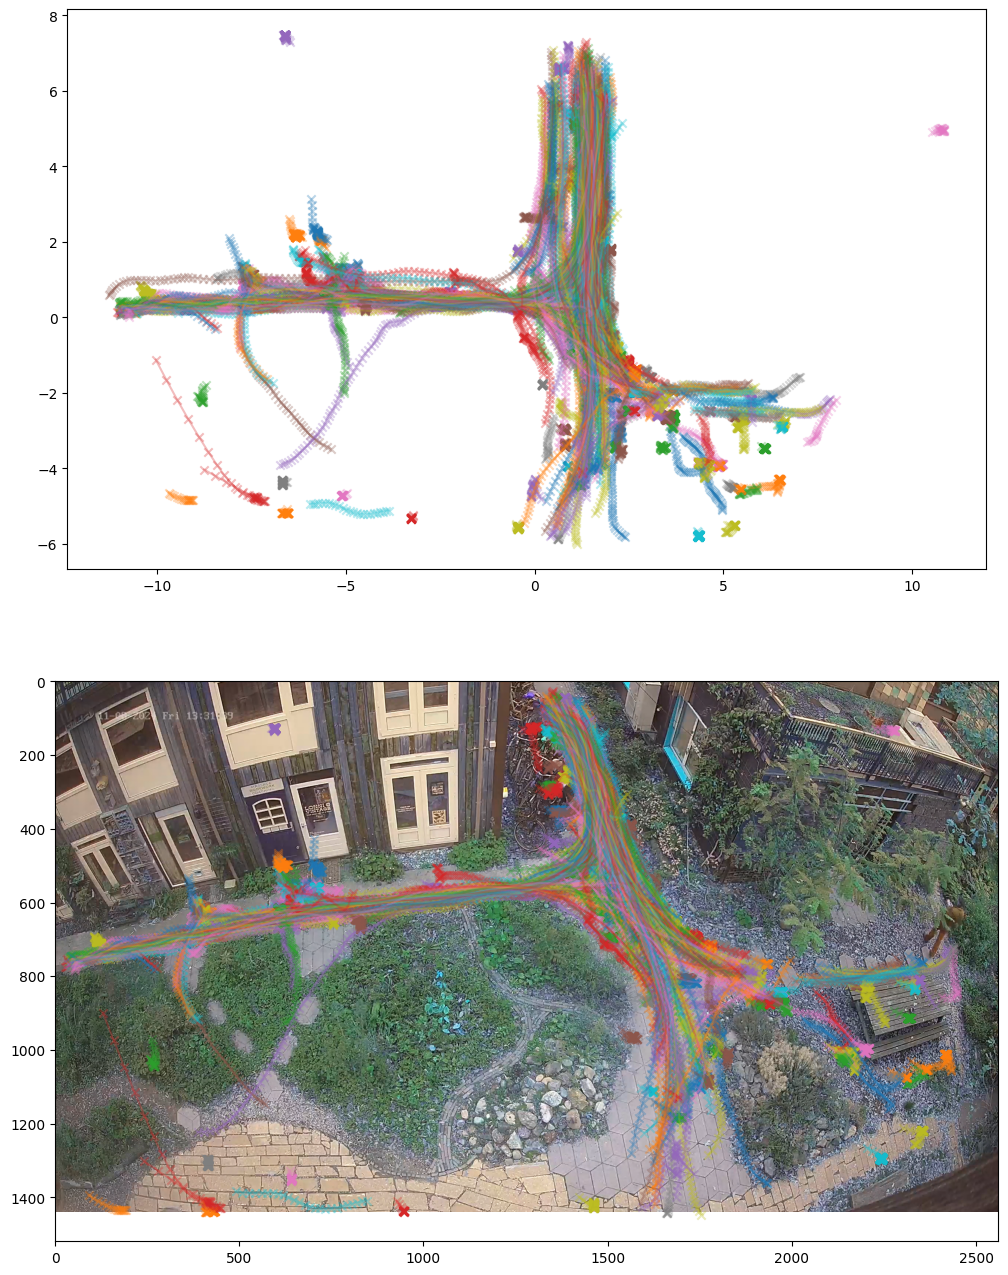

In [9]:
fig = plt.figure(figsize=(20,16))
ax1, ax2 = fig.subplots(2)

import cv2
# ax = fig1.gca()
# ax2 = fig2.gca()
im = cv2.imread("../DATASETS/hof2/output.png")
ax2.imshow(im)
ax1.set_aspect(1)
ax2.set_aspect(1)
nodes = []
for data_class in ['train', 'val', 'test']:
    target_dir = os.path.join(desired_source, data_class)
    for subdir, dirs, files in os.walk(target_dir):
        for file in files:
            if file.endswith('.txt'):
                print(data_class, file)
                input_data_dict = dict()
                full_data_path = os.path.join(subdir, file)
                nodes.extend(parse_txt(full_data_path, dt, ax1, ax2))
                # break
        # break
    # break
fig.show()
len(nodes)